In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as p
import PIL as pil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical,normalize
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras import regularizers
import seaborn as sns
%matplotlib inline
import seaborn as sns
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import classification_report,confusion_matrix



In [4]:
base='HAM10000_metadata.csv'

# **Accessing Dataset**

In [6]:
metadata=pd.read_csv(base)
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


# **Data Visualization**

In [7]:
#To analyse basics of Dataset we study first 5 rows of HAAM10000 Dataset
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [8]:
#Checking for NA
metadata.isna().isna().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [9]:
metadata.describe(include='all')

,lesion_id,image_id,dx,dx_type,age,sex,localization
count,10015,10015,10015,10015,9958.000000,10015,10015
unique,7470,10015,7,4,NaN,3,15
top,HAM_0003789,ISIC_0027419,nv,histo,NaN,male,back
freq,6,1,6705,5340,NaN,5406,2192
mean,NaN,NaN,NaN,NaN,51.863828,NaN,NaN
std,NaN,NaN,NaN,NaN,16.968614,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,40.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,50.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,65.000000,NaN,NaN


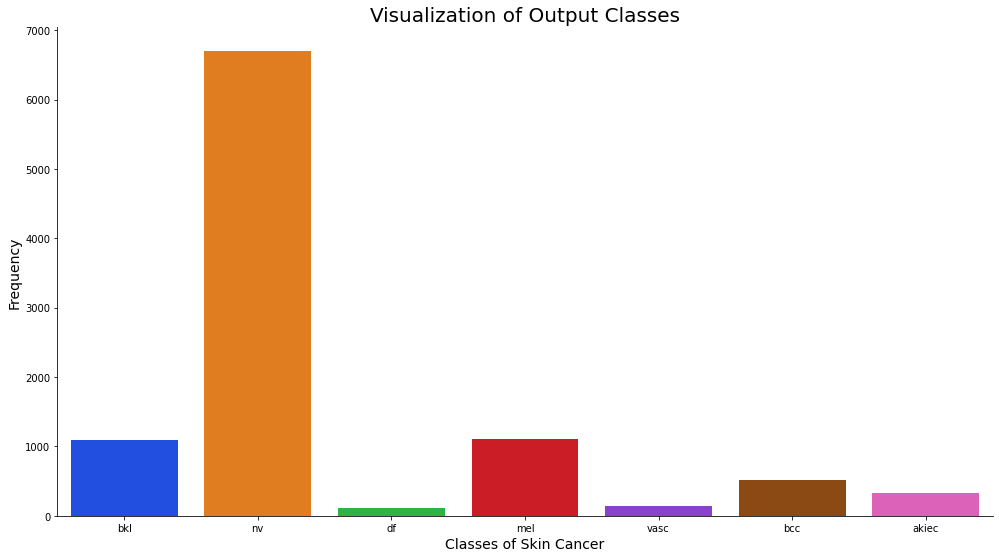

In [10]:

# We need to predict the cancer type, let's check the distribution of the values
g = sns.catplot(x="dx", kind="count", palette='bright', data=metadata)
g.fig.set_size_inches(16, 8)

g.ax.set_title('Visualization of Output Classes', fontsize=20)
g.set_xlabels('Classes of Skin Cancer', fontsize=14)
g.set_ylabels('Frequency', fontsize=14)

# Getting trainable from CSV file

In [12]:
df=pd.read_csv('hmnist_28_28_RGB.csv')
x=df.drop('label',axis=1)
y=df['label']
x=x.to_numpy()
x=x/255
y=to_categorical(y)

In [13]:
df

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,183,165,181,182,165,180,184,166,182,188,...,208,185,187,208,186,186,206,187,189,0
10011,2,3,1,38,33,32,121,104,103,132,...,96,79,76,24,23,21,3,4,1,0
10012,132,118,118,167,149,149,175,156,160,184,...,204,181,178,181,159,153,172,151,145,0
10013,160,124,146,164,131,152,167,127,146,169,...,185,162,167,184,157,166,185,162,172,0


In [14]:
#Since there are 7 classes only, we can label them manually 
label={
    ' Actinic keratoses':0,
    'Basal cell carcinoma':1,
    'Benign keratosis-like lesions':2,
    'Dermatofibroma':3,
    'Melanocytic nevi':4,
    'Melanoma':5,
    'Vascular lesions':6
}

# **Images**

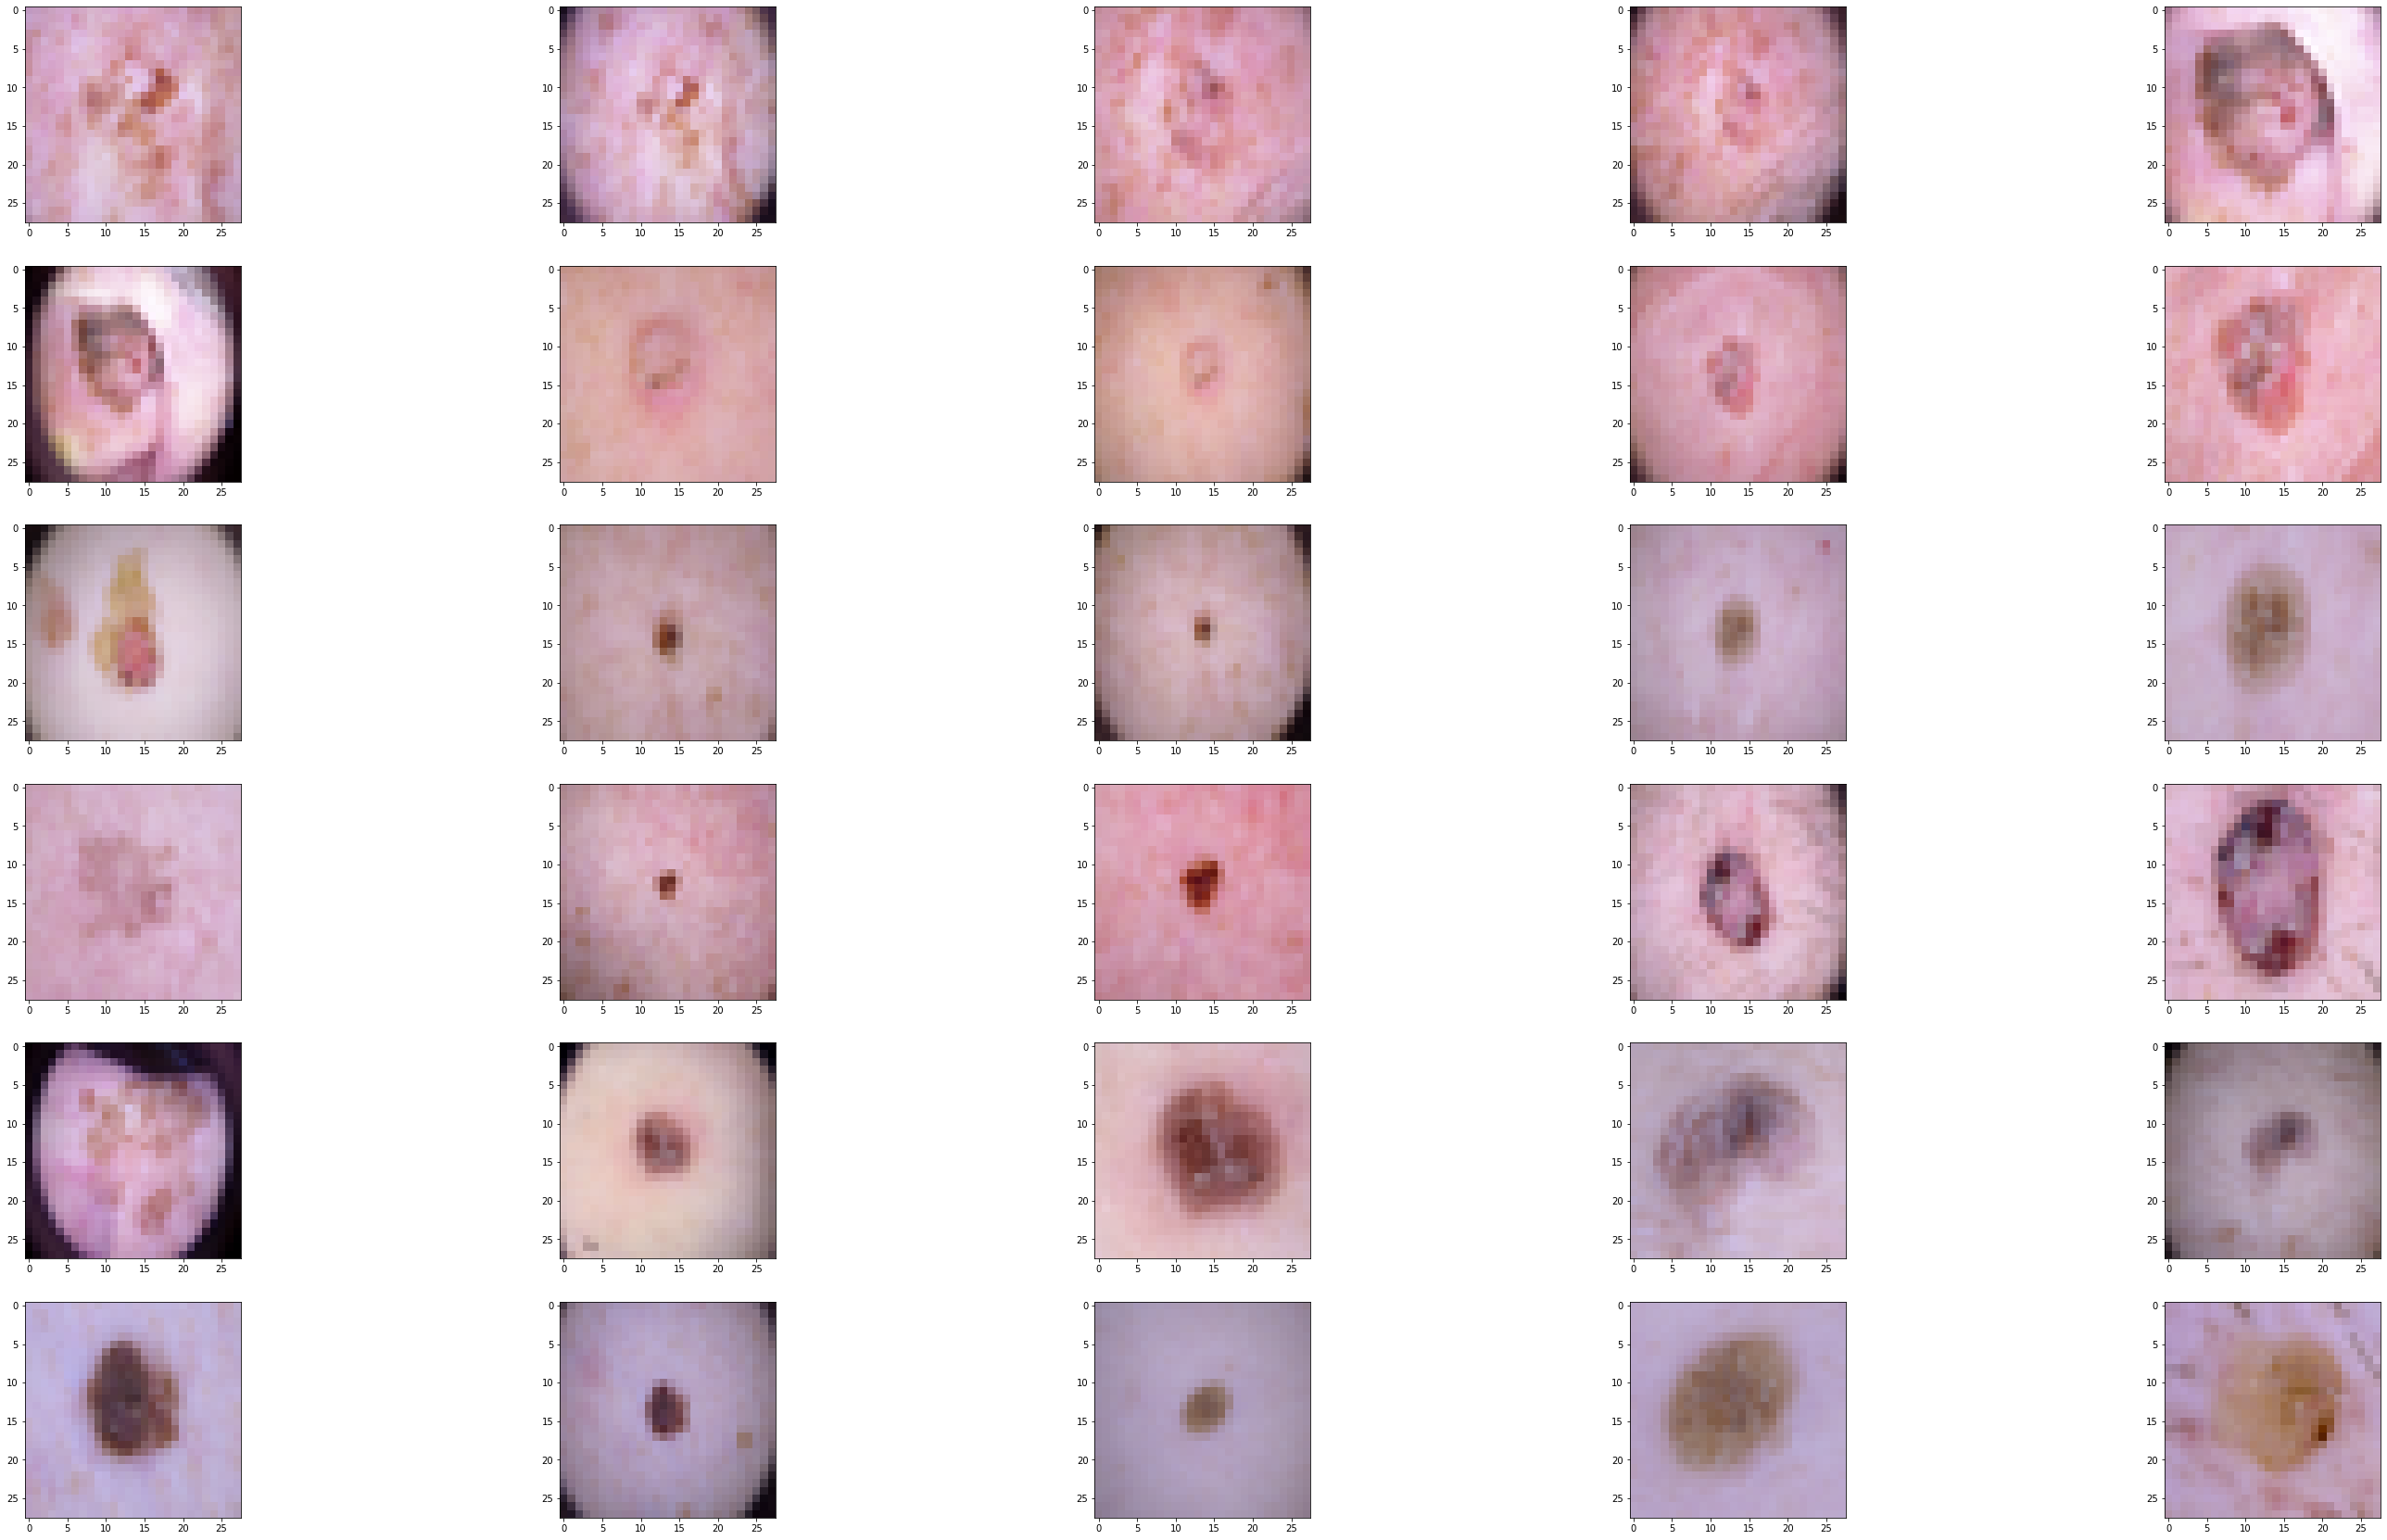

In [15]:
x=x.reshape(-1,28,28,3)
p.figure(figsize=(50,30))
for i in range(30):
    p.subplot(6,5,i+1)
    img=x[i]
    p.imshow(img)

# Spliting of Dataset 

In [16]:
trainx,trainy,testx,testy = train_test_split(x,y,test_size=0.02,random_state=42)

# Image Augmentation to expand Train data 

In [17]:
data_generator=ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='nearest')

In [18]:
data_generator.fit(trainx)

# CNN Model

In [19]:
#input_shape=(28,28,3)

model=Sequential()


model.add(Conv2D(64,(2,2),input_shape=(28,28,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())


model.add(Conv2D(512,(2,2),input_shape=(28,28,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))



model.add(Dropout(0.3))

model.add(Conv2D(1024,(2,2),input_shape=(28,28,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())


model.add(Dropout(0.4))

model.add(Conv2D(1024,(1,1),input_shape=(28,28,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))



model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(256,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))


model.add(Dense(7,activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy',Recall()])

2022-03-06 00:10:14.240206: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
#Reviewing our CNN model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 64)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 13, 13, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 512)       131584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 512)        0         
 2D)                                                             
                                                        

In [21]:
early=EarlyStopping(monitor='accuarcy',patience=4,mode='auto')

In [22]:
#Training our CNN
model.fit(trainx,testx,epochs=50,batch_size=90,validation_data=(trainy, testy),callbacks=[early])

Epoch 1/50
110/110 [==============================] - 135s 1s/step - loss: 4.0058 - accuracy: 0.6527 - recall: 0.5253 - val_loss: 3.2800 - val_accuracy: 0.0547 - val_recall: 0.0000e+00
Epoch 2/50
110/110 [==============================] - 121s 1s/step - loss: 1.6684 - accuracy: 0.6908 - recall: 0.5644 - val_loss: 2.8780 - val_accuracy: 0.0398 - val_recall: 0.0000e+00
Epoch 3/50
110/110 [==============================] - 116s 1s/step - loss: 1.1469 - accuracy: 0.7026 - recall: 0.5877 - val_loss: 2.5869 - val_accuracy: 0.1294 - val_recall: 0.1194
Epoch 4/50
110/110 [==============================] - 115s 1s/step - loss: 1.0068 - accuracy: 0.7160 - recall: 0.5997 - val_loss: 2.3772 - val_accuracy: 0.1493 - val_recall: 0.0498
Epoch 5/50
110/110 [==============================] - 110s 998ms/step - loss: 0.9398 - accuracy: 0.7187 - recall: 0.6151 - val_loss: 1.6474 - val_accuracy: 0.4527 - val_recall: 0.4328
Epoch 6/50
110/110 [==============================] - 94s 852ms/step - loss: 0.8800 

<Figure size 1080x360 with 0 Axes>

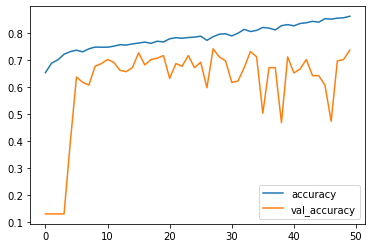

In [19]:
#Visualizing Training and Validation Accuracy
p.figure(figsize=(15,5))
loss=pd.DataFrame(model.history.history)
loss=loss[['accuracy','val_accuracy']]
loss.plot()

In [20]:
#Building a report 
predictions=model.predict_classes(trainy)

check=[]
for i in range(len(testy)):
    for j in range(7):
        if(testy[i][j]==1):
            check.append(j)
check=np.asarray(check)

print(classification_report(check,predictions))

              precision    recall  f1-score   support

           0       0.37      0.88      0.52         8
           1       0.47      0.64      0.54        11
           2       0.54      0.50      0.52        26
           3       0.00      0.00      0.00         3
           4       0.90      0.86      0.88       123
           5       1.00      0.67      0.80         3
           6       0.57      0.48      0.52        27

    accuracy                           0.74       201
   macro avg       0.55      0.57      0.54       201
weighted avg       0.75      0.74      0.74       201



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# Save model and weights
model.save("cancer_classifier.h5")
model.save_weights('cancer_classifier_weights',save_format='tf')

In [ ]:
# Predict on Data

def predictCancer(image_path):

    test_data = load_data(image_path)
    test_data = img_data_gen.flow_from_dataframe(dataframe=test_data,
                                          x_col='FilePaths',
                                          y_col='Labels',
                                          target_size=IMG_SIZE,
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=BATCH_SIZE,
                                          shuffle=False, # necessary fpr confusion matrix
                                          seed=1)
    predictions = model.predict(test_data)

    # Perform statistical normalization on data

    outputValues = [[class_labels],
                     [predictions]]

    return outputValues

test_image = '/Volumes/Extreme SSD/MakeDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Image_Test'
print(predictCancer(test_image))